<a href="https://colab.research.google.com/github/kpjaskie/SenSIP-IRES2020/blob/master/Machine_Learning_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Classification Algorithms

In this notebook, we will be performing different classification algorithms for comparison on simulated and real-world datasets.

In statistics and machine learning, classification is the problem of identifying to which of a set of categories or classes a new observation belongs.  This is done by creating a model from data whose class membership is known.  When the data belongs to one of two classes, this is refered to as **binary classification**.  When there are more than two classes represented,, this is called **multi-class classification**.

Examples of **binary classification** include determining whether an email is "spam" or "non-spam" or determining if a patient "is pregnant" or "is not pregnant".

Examples of **multi-class classification** include determening what is causing a patients illness (out of many possible diseases) based on observed characteristics of the patien (sex, blood pressure, presence or absence of certain symptoms, etc.) or identifying an animal, plant, or make and model of vehicle in a photograph.

![picture](https://miro.medium.com/max/972/1*SwXHlCzh-d9UqHOglp3vcA.png)

In this tutorial, we will mostly focus on binary classification using simulated datasets.  However, we will introduce some real-world examples towards the end.


In [26]:
# First, we need to import the relavent libraries
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# To create confusion matrices and metrics
from sklearn.metrics import confusion_matrix

import seaborn as sns; sns.set()  # for plotting confusion matrices
from tabulate import tabulate


# Generate Data

Let's make some simulated data to work with.  As mentioned above, we will start with only two classes so that we can perform binary classification.  In binary classification, we often name the classes "positive" and "negative".  If one of the classes is smaller than the other, it is typically called the positive class.

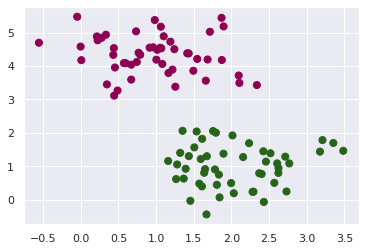

In [3]:
from sklearn.datasets import make_blobs

#Let's make some training data
X_sim_train, y_sim_train = make_blobs(n_samples=100, centers=2, random_state=0, cluster_std=0.60)
plt.scatter(X_sim_train[:, 0], X_sim_train[:, 1], c=y_sim_train, s=50, cmap='PiYG');

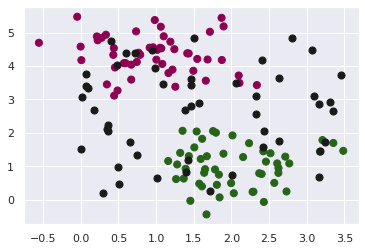

In [4]:
# generate random floating point values
from numpy.random import seed
from numpy.random import rand
# seed random number generator
seed(1)
# generate random numbers
X_sim_test = np.random.random((50,2))
X_sim_test[:,0] = 3.5 * X_sim_test[:,0]
X_sim_test[:,1] = 5 * X_sim_test[:,1]

plt.scatter(X_sim_train[:, 0], X_sim_train[:, 1], c=y_sim_train, s=50, cmap='PiYG');
plt.scatter(X_sim_test[:, 0], X_sim_test[:, 1], c='k', s=50);

# Evaluating a Classification Algorithm

Before we begin working with classification algorithms, we need to introduce some of the standard classification evaluation techniques so we will be able to differentiate a good classification model from a bad one.

We will discuss:
* Confusion Matrices
* Metrics including Accuracy, Recall, Precision, and F-score (also called the F1-score).


## Confusion Matrices

Machine Learning practitioners' first tool for evaluating classification models is to generate and inspect the confusion matrix.  A confusion matrix for a binary classification problem has two rows and two columns. The real answers often depicted as the columns and the model predicted answers are given as the rows, but this is not always true - you have to look at the axis labels to be sure.
<br/><br/>

The image below depicts a confusion matrix for a pregnancy test.  A real confusion matrix will have numbers in each cell showing how many data samples your classification model classified into each category: True Positives (TP), False Positives (FP), False Negatives (FN), or True Negatives (TN).

<div>
<img src="http://drive.google.com/uc?export=view&id=1qAFkAshy_JCGORVioC1sMaVZXKVLsJLn" width="600"/>
</div>


In Python, confusion matrices are often created using a seaborn heatmap.  So an example for a model that classifies pregnancy like above, might look like the following.  Play around with the numbers to see how the confusion matrix changes.



Ideally, we'd like to have a confusion matrix where the True Positives and True Negatives were high and the False Positives and False Negatives were low.  When this is true, the diagnonal from top left to bottom right would have large numbers and everywhere else would be low.

## Evaluation Metrics

While the confusion matrices described above are increadibly useful in evaluating how your model is performing, sometimes it's nice to have a **summary statistic** or a single value to evaluate your model.  These are often called **metrics**.  Here, we're going to go through the most commonly used classification metrics.  These metrics all use the TP, FP, TN, and FN shown in the confusion matrix above.

### Accuracy

A model's accuracy is probably the most commonly used classification metric.  

The accuracy is calculated as:
$$ Accuracy = \frac{TP + TN}{TP + FP + TN + FN} $$

This accuracy can either be calculated manually using this formula, or you can ask sklearn to calculate it for you.  To have sklearn calculate it for you, you would need the following two lines of code:

```
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_real, y_predicted)
```

The accuracy and other metrics calculated below use the TP, TN, FP, FN values entered above for the confusion matrix.  Double click on the field below to see the code used for this calculation.

In [6]:
#@title Calculation

accuracy_metric = (TP + TN)/(TP + FP + TN + FN)

print("Accuracy = (", TP, "+", TN, ")/(", TP, "+", FP, "+", TN, "+", FN, ") =",
      round(accuracy_metric * 100, 2), "% ")

Accuracy = ( 200 + 175 )/( 200 + 20 + 175 + 37 ) = 86.81 % 


### Precision and Recall

Two other important metrics that are commonly used are the Precision and the Recall.  

<div>
<img src="http://drive.google.com/uc?export=view&id=1A-x7MJeGDoQrxKXWfGZXpKoLDahUHHhq" width="700"/>
</div>

Precision and recall are important in many applications and models can be adjusted to increase one, often at the expense of the other.

* For example, when predicting a deadly disease, doctors might prefer to scare somebody with a false positive instead of missing somebody through a false negative.  In this case, having a high recall is preferred to precision.

* In other cases, such as when a credit card company declines a credit card due to suspected fraud, they're going to make their customers very unhappy if there was no fraud.  In this case, the credit card company would prefer a higher precision over a high recall.

Understanding the differences and tradeoffs between these two metrics, helps a data scientist focus on what's best for the situation.

Try changing the values up above to see how the precision and recall change.

In [7]:
#@title Calculation

precision_metric = TP/(TP + FP)
recall_metric = TP/(TP + FN)

print("Precision = (", TP, ")/(", TP, "+", FP, ") =",
      round(precision_metric * 100, 2), "% ")

print("\nRecall = (", TP, ")/(", TP, "+", FN, ") =",
      round(recall_metric * 100, 2), "% ")

Precision = ( 200 )/( 200 + 20 ) = 90.91 % 

Recall = ( 200 )/( 200 + 37 ) = 84.39 % 


### F-Score



## Experimentation

Now that you've had an overview on the different classification evaluation metrics, let's play with some numbers.  For simplicity, we're going to use disease X diagnosis as an example.  Since we assume that most people that are tested will NOT have X, those with the disease will be considered **positive** and those without will be considered **negative**.

Remember: 
* TP = Has X classified as having X (correct)
* FP = Does not have X but classified as having X (incorrect)
* FN = Has X but classified as not having X (incorrect)
* TN = Does not have X and classified as not having X (correct)

In [13]:
#@title Data

TP =  200#@param {type:"integer"}
FP = 20 #@param {type:"integer"}
FN = 37 #@param {type:"integer"}
TN = 175 #@param {type:"integer"}

y_real = np.concatenate((np.ones((TP+FN,)), np.zeros((TN+FP,))))
y_predicted = np.concatenate((np.ones((TP,)), np.zeros((FN + TN,)), 
                              np.ones((FP,))))

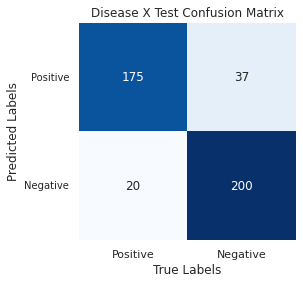

In [14]:
#@title Confusion Matrix

CM_example = confusion_matrix(y_real, y_predicted)

ax = sns.heatmap(CM_example.T, square=True, annot=True, 
                 fmt='d', cbar=False, cmap="Blues")

ax.set_xticklabels(('Positive','Negative'))
ax.set_yticklabels(('Positive','Negative'), 
    rotation=0, fontsize="10", va="center")

plt.xlabel("True Labels")
plt.ylabel("Predicted Labels");
plt.title("Disease X Test Confusion Matrix")
plt.show()

In [28]:
#@title Evaluation Metrics

accuracy_ex = (TP + TN)/(TP + FP + TN + FN)
precision_ex = TP/(TP + FP)
recall_ex = TP/(TP + FN)
fscore_ex = 2 * (precision_ex * recall_ex)/(precision_ex + recall_ex)


print(tabulate([['Accuracy', accuracy_ex], 
                ['Precision', precision_ex],
                ['Recall', recall_ex],
                ['F-score', fscore_ex]], 
               headers=['Metric', 'Value']))


Metric        Value
---------  --------
Accuracy   0.868056
Precision  0.909091
Recall     0.843882
F-score    0.875274


# Logistic Regression


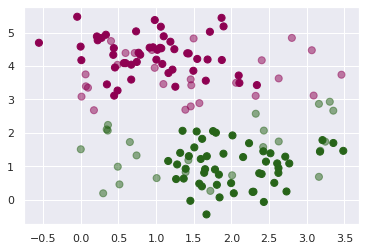

In [9]:
from sklearn.linear_model import LogisticRegression
from scipy import stats

#First, let's look at the simulated data
LR_model = LogisticRegression(random_state=0)

sim_model = LR_model.fit(X_sim_train, y_sim_train)
y_hat = sim_model.predict(X_sim_test)
prob_estimates = np.sort(sim_model.predict_proba(X_sim_test))


plt.figure(0)
plt.scatter(X_sim_train[:, 0], X_sim_train[:, 1], c=y_sim_train, s=50, cmap='PiYG');
plt.scatter(X_sim_test[:, 0], X_sim_test[:, 1], c=y_hat, s=50, cmap='PiYG', alpha=0.5);


In [10]:
from sklearn.metrics import plot_confusion_matrix

CM = plot_confusion_matrix(sim_model, X, X_sim_test

SyntaxError: ignored

#Support Vector Machines

A Support Vector Machine 

In [ ]:
xfit = np.linspace(-1, 3.5)
plt.scatter(X[:, 0], X[:, 1], c=y, s=50, cmap='PiYG')
#plt.plot([0.6], [2.1], 'x', color='red', markeredgewidth=2, markersize=10)

for m, b in [(1, 0.65), (0.5, 1.6), (-0.2, 2.9)]:
    plt.plot(xfit, m * xfit + b, '-k')

#Neural Network Classifiers